In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from collections import Counter, defaultdict
from operator import itemgetter
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../scripts')))

from PredictTestData import PredictTest

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
import os
from sklearn.model_selection import KFold
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


In [10]:

kms_to_ms = 1/3.6
def rrmse(obs, Pred):
    return np.sqrt(np.mean(((obs - Pred)/obs)**2))

In [11]:
def convertStrList(strList):
    
    return [eval(i) for i in strList[1:-1].split(" ")]
    #try:
       # return [eval(i) for i in strList[1:-1].split(" ")] 
   # except IndentationError:
        
        
Root_data_path = os.path.join('../Data')

In [12]:
data = pd.read_csv(os.path.join(Root_data_path, "data_train.csv"))
data_val = pd.read_csv(os.path.join(Root_data_path, "data_validation.csv"))
                       

Response = ['1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17']



In [13]:
Explanatory = np.array(['EPSG3979_x', 'EPSG3979_y', 'ASP100m.tif', 'ASP500m.tif',
       'ASP1000m.tif', 'ASP1500m.tif', 'ASP2000m.tif', 
       'MXC100m.tif', 'MXC500m.tif', 'MXC1000m.tif', 'MXC1500m.tif',
       'MXC2000m.tif', 'MNC100m.tif', 'MNC500m.tif', 'MNC1000m.tif',
       'MNC1500m.tif', 'MNC2000m.tif', 'RGI100m.tif', 'RGI500m.tif',
       'RGI1000m.tif', 'RGI1500m.tif', 'RGI2000m.tif', 'SLP100m.tif',
       'SLP500m.tif', 'SLP1000m.tif', 'SLP1500m.tif', 'SLP2000m.tif',
       'DVE100m.tif', 'DVE500m.tif', 'DVE1000m.tif',
       'DVE1500m.tif', 'DVE2000m.tif', 'DFE100m.tif', 'DFE500m.tif',
       'DFE1000m.tif', 'DFE1500m.tif', 'DFE2000m.tif', 'EPC100m.tif',
       'EPC500m.tif', 'EPC1000m.tif', 'EPC1500m.tif', 'EPC2000m.tif',
       'RTP100m.tif', 'RTP500m.tif', 'RTP1000m.tif', 'RTP1500m.tif',
       'RTP2000m.tif','DoG_1_5.tif', 'DoG_1_10.tif', 'DoG_5_10.tif', 'DoG_3_5.tif',
       'DoG_10_20.tif', 'DoG_10_15.tif', 'DoG_1_20.tif', 'DoG_5_20.tif',
       'LoG_1m.tif', 'LoG_5m.tif', 'LoG_10m.tif', 'LoG_15m.tif',
       'LoG_20m.tif', 'GCV100m.tif', 'GCV500m.tif', 'GCV1000m.tif',
       'GCV1500m.tif', 'GCV2000m.tif', 'ALOS_100m.tif',
       'MINC100m.tif', 'MINC500m.tif', 'MINC1000m.tif', 'MINC1500m.tif',
       'MINC2000m.tif', 'PCUR1000m.tif', 'PCUR1500m.tif', 'PCUR2000m.tif',
       'PCUR100m.tif', 'PCUR500m.tif', 'TCUR100m.tif', 'TCUR500m.tif',
       'TCUR1000m.tif', 'TCUR1500m.tif', 'TCUR2000m.tif', 'SDS100m.tif',
       'SDS500m.tif', 'SDS1000m.tif', 'SDS1500m.tif', 'SDS2000m.tif',
       'SAR100m.tif', 'SAR500m.tif', 'SAR1000m.tif', 'SAR1500m.tif',
       'SAR2000m.tif', 'TOCUR100m.tif', 'TOCUR500m.tif', 'TOCUR1000m.tif',
       'TOCUR1500m.tif', 'TOCUR2000m.tif', 'RoughL_100m', 'RoughL_1km',
       'RoughL_1km5',  'RoughL_2km', 
       'RoughL_500m',  'SeaDist', 'GMP_1', 'GMP_2', 'GMP_3',
       'GMP_5', 'GMP_6', 'GMP_7', 'GMP_8', 'GMP_9', 'GMP_10', 
       'PLC_5', 'PLC_6', 'PLC_7'])

Explanatory_dict = {'EPSG3979_x':'XGEO','EPSG3979_y':'YGEO', 'ASP100m.tif':'ASPC_100m', 'ASP500m.tif':'ASPC_500m', 'ASP1000m.tif':'ASPC_1000m',
               'ASP1500m.tif':'ASPC_1500m', 'ASP2000m.tif':'ASPC_2000m',  'MXC100m.tif':'MXCV_100m','MXC500m.tif':'MXCV_500m', 
               'MXC1000m.tif':'MXCV_1000m', 'MXC1500m.tif':'MXCV_1500m', 'MXC2000m.tif':'MXCV_2000m','MNC100m.tif':'MNCV_100m', 'MNC500m.tif':'MNCV_500m',
               'MNC1000m.tif':'MNCV_1000m', 'MNC1500m.tif':'MNCV_1500m','MNC2000m.tif':'MNCV_2000m', 'RGI100m.tif':'RUGI_100m', 'RGI500m.tif':'RUGI_500m', 
               'RGI1000m.tif':'RUGI_1000m','RGI1500m.tif':'RUGI_1500m', 'RGI2000m.tif':'RUGI_2000m', 'SLP100m.tif':'SLPE_100m', 'SLP500m.tif':'SLPE_500m',
               'SLP1000m.tif':'SLPE_1000m', 'SLP1500m.tif':'SLPE_1500m', 'SLP2000m.tif':'SLPE_2000m', 'DVE100m.tif':'DVME_100m', 'DVE500m.tif':'DVME_500m', 
               'DVE1000m.tif':'DVME_1000m', 'DVE1500m.tif':'DVME_1500m','DVE2000m.tif':'DVME_2000m', 'DFE100m.tif':'DFME_100m', 'DFE500m.tif':'DFME_500m',
               'DFE1000m.tif':'DFME_1000m','DFE1500m.tif':'DFME_1500m', 'DFE2000m.tif':'DFME_2000m', 'EPC100m.tif':'ELVP_100m', 'EPC500m.tif':'ELVP_500m',
               'EPC1000m.tif':'ELVP_1000m', 'EPC1500m.tif':'ELVP_1500m', 'EPC2000m.tif':'ELVP_2000m', 'RTP100m.tif':'RTGP_100m','RTP500m.tif':'RTGP_500m', 
               'RTP1000m.tif':'RTGP_1000m', 'RTP1500m.tif':'RTGP_1500m', 'RTP2000m.tif':'RTGP_2000m', 'DoG_1_5.tif':'DOGS_100m_500m','DoG_1_10.tif':'DOGS_100m_1000m',
               'DoG_5_10.tif':'DOGS_500m_1000m', 'DoG_3_5.tif':'DOGS_300m_500m', 'DoG_10_20.tif':'DOGS_1000m_2000m','DoG_10_15.tif':'DOGS_1000m_1500m', 'DoG_1_20.tif':'DOGS_100m_2000m',
               'DoG_5_20.tif':'DOGS_500m_2000m', 'LoG_1m.tif':'LPGS_100m','LoG_5m.tif':'LPGS_500m', 'LoG_10m.tif':'LPGS_1000m', 'LoG_15m.tif':'LPGS_1500m', 
               'LoG_20m.tif':'LPGS_2000m', 'GCV100m.tif':'GSCV_100m', 'GCV500m.tif':'GSCV_500m', 'GCV1000m.tif':'GSCV_1000m', 'GCV1500m.tif':'GSCV_1500m',
               'GCV2000m.tif':'GSCV_2000m', 'ALOS_100m.tif':'ELVT_100m', 'MINC100m.tif':'MICV_100m', 'MINC500m.tif':'MICV_500m','MINC1000m.tif':'MICV_1000m', 
               'MINC1500m.tif':'MICV_1500m', 'MINC2000m.tif':'MICV_2000m', 'PCUR1000m.tif':'PLCV_1000m','PCUR1500m.tif':'PLCV_1500m', 'PCUR2000m.tif':'PLCV_2000m', 
               'PCUR100m.tif':'PLCV_100m', 'PCUR500m.tif':'PLCV_500m', 'TCUR100m.tif':'TGCV_100m', 'TCUR500m.tif':'TGCV_500m', 'TCUR1000m.tif':'TGCV_1000m', 
               'TCUR1500m.tif':'TGCV_1500m','TCUR2000m.tif':'TGCV_2000m', 'SDS100m.tif':'STDS_100m', 'SDS500m.tif':'STDS_500m', 'SDS1000m.tif':'STDS_1000m',
               'SDS1500m.tif':'STDS_1500m', 'SDS2000m.tif':'STDS_2000m', 'SAR100m.tif':'SART_100m', 'SAR500m.tif':'SART_500m','SAR1000m.tif':'SART_1000m',
               'SAR1500m.tif':'SART_1500m','SAR2000m.tif':'SART_2000m', 'TOCUR100m.tif':'TLCV_100m','TOCUR500m.tif':'TLCV_500m', 'TOCUR1000m.tif':'TLCV_1000m',
               'TOCUR1500m.tif':'TLCV_1500m','TOCUR2000m.tif':'TLCV_2000m', 'RoughL_100m':'RGLH_100m', 'RoughL_1km':'RGLH_1000m', 'RoughL_1km5':'RGLH_1500m',
               'RoughL_1km8':'RGLH_1800m', 'RoughL_2km':'RGLH_2000m', 'RoughL_300m':'RGLH_300m', 'RoughL_500m':'RGLH_500m',
               'RoughL_700m':'RGLH_700m', 'SeaDist':'DSEA', 'GMP_1':'GMPG_1', 'GMP_2':'GMPG_2', 'GMP_3':'GMPG_3', 'GMP_5':'GMPG_5',
       'GMP_6':'GMPG_6', 'GMP_7':'GMPG_7', 'GMP_8':'GMPG_8', 'GMP_9':'GMPG_9', 'GMP_10':'GMPG_10', 'PLC_5':'PNCL_5',
       'PLC_6':'PNCL_6', 'PLC_7':'PNCL_7'}

In [14]:
VarXSelected =( pd.read_csv(os
                            .path.normpath
                            (os.path.join('../Results/varSelect.csv'))))

VarXSelected = VarXSelected.rename(columns={"Unnamed: 0":"model"}).set_index("model").loc[:, 'P1':'P14']

In [15]:
trim = 14
Methods =VarXSelected.index.values
Quantiles = VarXSelected.columns.values[:trim]


In [16]:
def cross_validate(Q, VM,regMeth = "lr"):
    kfold = KFold(n_splits=5, random_state=38974, shuffle=True)
    r2_ls = []
    rmse_ls = []
    rrmse_ls = []
    mae_ls = []
    vary = Quantiles[Q][1:]
    varX = convertStrList(VarXSelected.loc[Methods[VM], Quantiles[Q]])
    for train_ix, test_ix in kfold.split(data):
        data_train, data_test = data.iloc[train_ix], data.iloc[test_ix]
        predY = np.array(PredictTest(data_train, data_test, varX, vary, np.linspace(0.1, 20, 100), regMeth)) 
        ResidualTrain = (data_train[vary] - PredictTest(data_train, data_train, varX, vary, np.linspace(0.1, 20, 100), regMeth)) 
        OkModel = OrdinaryKriging(data_train["EPSG3979_x"], data_train["EPSG3979_y"], ResidualTrain)
        residualPred = np.array(OkModel.execute("points", data_test["EPSG3979_x"], data_test["EPSG3979_y"])[0]) 
        Y_pred = (predY + residualPred) * kms_to_ms
        Y_true = data_test[vary] * kms_to_ms
        _r2 = r2_score(Y_true, Y_pred)
        _rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
        _rrmse = _rmse / np.mean(Y_true)
        _mae = mean_absolute_error(Y_true, Y_pred)
        r2_ls.append(_r2)
        rmse_ls.append(_rmse)
        rrmse_ls.append(_rrmse)
        mae_ls.append(_mae)
    return np.mean(r2_ls), np.mean(rmse_ls), np.mean(rrmse_ls), np.mean(mae_ls)


cv_res = {}

for Q in range(len(Quantiles)):
    for VM in range(len(Methods)):
        P = Quantiles[Q]
        M = Methods[VM]
        cv_res[(P, M)] = cross_validate(Q, VM, "lr")


In [17]:
col_rename = {'LassoFeat':'LASSO', 'EnetFeat':'ENET', 'MRFeat':'MRMR', 'FFSFeat':'FSWR', 'GAFeat':'GALG', 'RFEFeat':'RFES'}
(pd.DataFrame(cv_res).T.rename(columns={0:"r2", 1:"rmse", 2:"rrmse", 3:"mae"})
 .reset_index()
 .rename(columns={"level_0":"Quantile", "level_1":"Method"})
 .assign(r2 = lambda x: np.where(x["r2"] < 0, 0, x["r2"]))
 .groupby("Method").mean()
 .reset_index()
 .replace(col_rename)
 .sort_values('Method')
 )

,Method,r2,rmse,rrmse,mae
0,ENET,0.410204,1.667639,0.245923,1.238367
1,FSWR,0.124703,2.978117,0.346860,1.698632
2,GALG,0.509622,1.432082,0.222324,1.120329
3,LASSO,0.408364,1.659074,0.246243,1.239326
4,MRMR,0.416584,1.645376,0.244376,1.230112
5,RFES,0.316511,1.701905,0.271674,1.237802


In [18]:
def Rk_score(Q, VM, regMeth = "lr"):
    vary = Quantiles[Q][1:]
    varX = convertStrList(VarXSelected.loc[Methods[VM], Quantiles[Q]])

    predY = np.array(PredictTest(data, data_val, varX, vary, np.linspace(0.1, 20, 100), regMeth))

    ResidualTrain = data[vary] - PredictTest(data, data, varX, vary, np.linspace(0.1, 20, 100), regMeth)

    OkModel = OrdinaryKriging(data["EPSG3979_x"], data["EPSG3979_y"], ResidualTrain)

    residualPred = np.array(OkModel.execute("points", data_val["EPSG3979_x"], data_val["EPSG3979_y"])[0])

    Y_pred = predY + residualPred

    return data_val[vary], Y_pred, predY, vary

In [19]:
lr_resultsR2_ROK  = np.zeros((len(Quantiles), len(Methods)))
lr_resultsRMSE_ROK  = np.zeros((len(Quantiles), len(Methods)))
lr_resultsMAE_ROK = np.zeros((len(Quantiles), len(Methods)))
lr_resultsRRMSE_ROK  = np.zeros((len(Quantiles), len(Methods)))

lr_resultsR2_REG  = np.zeros((len(Quantiles), len(Methods)))
lr_resultsRMSE_REG  = np.zeros((len(Quantiles), len(Methods)))
lr_resultsMAE_REG = np.zeros((len(Quantiles), len(Methods)))
lr_resultsRRMSE_REG  = np.zeros((len(Quantiles), len(Methods)))




for Q in range(len(Quantiles)):
    for VM in range(len(Methods)):
        
        Obs, Pred, predY, vary = Rk_score(Q, VM, "lr")
        
        lr_resultsR2_REG[Q, VM] = r2_score(Obs, predY)
        lr_resultsRMSE_REG[Q, VM] = np.sqrt(mean_squared_error(Obs, predY))*kms_to_ms
        lr_resultsMAE_REG[Q, VM] = mean_absolute_error(Obs, predY)*kms_to_ms
        lr_resultsRRMSE_REG[Q, VM] = rrmse(Obs, predY)
        
        
        lr_resultsR2_ROK[Q, VM] = r2_score(Obs, Pred)
        lr_resultsRMSE_ROK[Q, VM] = np.sqrt(mean_squared_error(Obs, Pred))*kms_to_ms
        lr_resultsMAE_ROK[Q, VM] = mean_absolute_error(Obs, Pred)*kms_to_ms
        lr_resultsRRMSE_ROK[Q, VM] = rrmse(Obs, Pred)
        


In [20]:
pd.DataFrame(lr_resultsRRMSE_REG, index = Quantiles, columns = Methods).to_clipboard()

In [21]:
lr_resultsR2_ROK[lr_resultsR2_ROK < 0] = 0
col_rename = {'LassoFeat':'LASSO', 'EnetFeat':'ENET', 'MRFeat':'MRMR', 'FFSFeat':'FSWR', 'GAFeat':'GALG', 'RFEFeat':'RFES'}
AVG_all_metric = (pd.DataFrame({'R2':lr_resultsR2_ROK.mean(0), 
               'RMSE':lr_resultsRMSE_ROK.mean(0), 
               'RRMSE':lr_resultsRRMSE_ROK.mean(0), 
            
               'MAE':lr_resultsMAE_ROK.mean(0)}, index=Methods)
 .rename(col_rename))

In [22]:
pd.DataFrame(lr_resultsR2_REG)

,0,1,2,3,4,5
0,0.540008,0.408285,0.433850,0.461720,0.389216,-2.095301
1,0.480754,0.462049,0.470141,0.491698,0.388385,-0.494094
2,0.627315,0.560211,0.542083,0.686314,0.385618,0.066821
3,0.664743,0.703276,0.221103,0.636814,0.141583,0.375664
4,0.647187,0.682997,0.441498,0.545032,0.283424,-0.024373
5,0.621663,0.649413,0.445435,0.656280,0.427586,0.030256
6,0.562333,0.593638,0.602590,0.623514,0.567741,-0.698481
7,0.539695,0.546987,0.593046,0.591105,0.539930,0.072835
8,0.554062,0.551129,0.516800,0.540653,0.409919,0.178133
9,0.516538,0.487365,0.338088,0.556449,0.378623,0.370312


In [23]:
(AVG_all_metric.round(3)
 #.to_clipboard()
)

,R2,RMSE,RRMSE,MAE
LASSO,0.596,1.231,0.207,0.869
ENET,0.559,1.312,0.210,0.911
GALG,0.491,1.438,0.233,1.002
MRMR,0.602,1.226,0.211,0.847
RFES,0.459,1.506,0.240,1.053
FSWR,0.137,2.307,0.353,1.555


In [24]:
MetricREG = lr_resultsRRMSE_REG
MetricROK = lr_resultsRRMSE_ROK
MetricName = 'RRMSE'
lr_results_REG_df = pd.DataFrame(MetricREG.T , index=Methods, columns=Quantiles).rename(col_rename)
lr_results_ROK_df = pd.DataFrame(MetricROK.T , index=Methods, columns=Quantiles).rename(col_rename)

Metric_res = (lr_results_ROK_df
             .merge(lr_results_REG_df, left_index=True, right_index=True, suffixes=['_ROK', '_REG']).T
             .reset_index().rename(columns = {'index':'quantile'})
             .assign(OK_reg = lambda df: df['quantile']
                     .str.split('_').str[1], quantile = lambda df:df['quantile'].str.split('_').str[0])
             #.set_index('quantile')

            )



In [25]:

pd.DataFrame(lr_resultsR2_REG.T , index=Methods, columns=Quantiles).rename(col_rename).mean(1)

LASSO    0.531382
ENET     0.519992
GALG     0.456815
MRMR     0.531214
RFES     0.398827
FSWR    -0.110472
dtype: float64

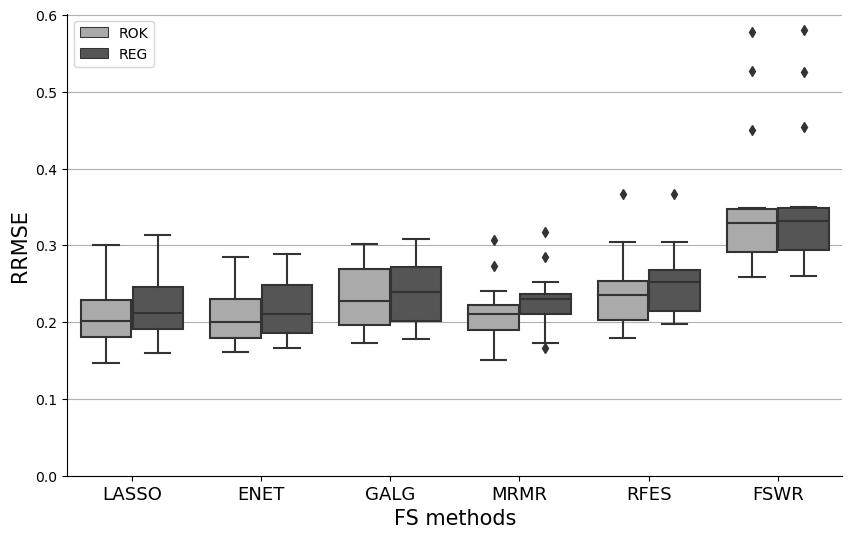

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
FSM = Metric_res.select_dtypes('float').columns
temp = Metric_res.set_index(['quantile', 'OK_reg']).melt(value_vars=FSM, value_name=MetricName, ignore_index=False)

sns.boxplot(temp.reset_index(), x='variable', y=MetricName, hue='OK_reg', palette='binary', ax=ax, zorder=5)
ax.set_axisbelow(True)
ax.grid(axis='y', zorder=10)
ax.set_xlabel('FS methods', fontsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks(ax.get_xticks(), labels= FSM, fontsize=13)

#ax.set_yticks(np.arange(0.1, 0.9, 0.1), np.arange(0.1, 0.9, 0.1).round(2), fontsize=13)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel(MetricName, fontsize=15)
ax.legend(title='', loc='upper left')


In [27]:
(Metric_res.groupby('OK_reg').mean()
 .T
 #.drop(index='FFSL')
 .assign(percent_Decrease = lambda df: 100*((df.ROK - df.REG) /df.REG) )
 .mean()
)

OK_reg
REG                 0.251738
ROK                 0.242386
percent_Decrease   -3.998828
dtype: float64

In [28]:
FSM = Metric_res.select_dtypes('float').columns.sort_values()

ttest_res_stat = np.zeros((len(FSM), len(FSM)))
ttest_res_pval = np.zeros((len(FSM), len(FSM)))

for i, fs1 in enumerate(FSM):
    for j, fs2 in enumerate(FSM):
        if fs1 == fs2:
            continue
        else: 
            #res_test = weightstats.ttest_ind(RRMSE_res[fs1], RRMSE_res[fs2], alternative='larger')
            res_test = stats.ttest_rel(Metric_res.query('OK_reg == "ROK" ')[fs1],
                                       Metric_res.query('OK_reg == "ROK" ')[fs2], 
                                      alternative='greater')

            #res_test = stats.ttest_ind(Metric_res.query('OK_reg == "ROK" ')[fs1],
            #                           Metric_res.query('OK_reg == "ROK" ')[fs2], 
            #                           alternative='greater')
            
            ttest_res_stat[i, j] = res_test[0]
            ttest_res_pval[i, j] = res_test[1]

In [29]:
(pd.DataFrame(ttest_res_stat, index= FSM, columns=FSM).round(2)
#.to_clipboard()

)
#pd.DataFrame(ttest_res_pval, index= FSM, columns=FSM).round(2)

,ENET,FSWR,GALG,LASSO,MRMR,RFES
ENET,0.00,-4.69,-2.03,0.59,-0.18,-1.88
FSWR,4.69,0.00,3.46,4.77,4.51,3.14
GALG,2.03,-3.46,0.00,2.26,2.21,-0.78
LASSO,-0.59,-4.77,-2.26,0.00,-0.91,-2.09
MRMR,0.18,-4.51,-2.21,0.91,0.00,-1.99
RFES,1.88,-3.14,0.78,2.09,1.99,0.00


In [30]:
pd.DataFrame(ttest_res_pval, index= FSM, columns=FSM).round(2)

,ENET,FSWR,GALG,LASSO,MRMR,RFES
ENET,0.00,1.0,0.97,0.28,0.57,0.96
FSWR,0.00,0.0,0.00,0.00,0.00,0.00
GALG,0.03,1.0,0.00,0.02,0.02,0.78
LASSO,0.72,1.0,0.98,0.00,0.81,0.97
MRMR,0.43,1.0,0.98,0.19,0.00,0.97
RFES,0.04,1.0,0.22,0.03,0.03,0.00


In [31]:
(
    Metric_res.query('OK_reg == "ROK" ')
    .select_dtypes('float')
    .mean()
)

LASSO    0.207058
ENET     0.209858
GALG     0.232528
MRMR     0.210922
RFES     0.240497
FSWR     0.353455
dtype: float64

(0.0, 0.6)

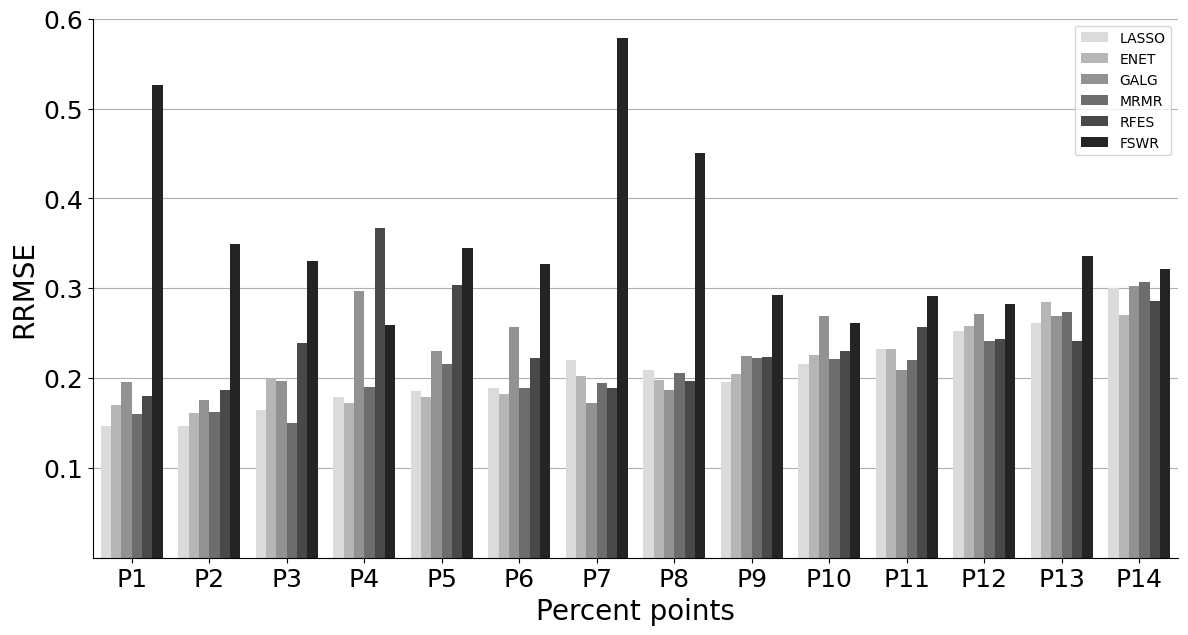

In [32]:
fig, ax = plt.subplots(figsize=(14, 7))

temp = Metric_res.query('OK_reg == "ROK"').set_index('quantile').select_dtypes('float').melt(ignore_index=False).reset_index()

sns.barplot(temp, x='quantile', y='value', hue='variable', palette='binary', ax=ax)
ax.set_axisbelow(True)
ax.grid(axis='y')

ax.set_xlabel('Percent points', fontsize=20)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks(ax.get_xticks(), labels= temp['quantile'].unique(), fontsize=18)

ax.set_yticks(np.arange(0.1, 0.9, 0.1), np.arange(0.1, 0.9, 0.1).round(2), fontsize=18)
ax.set_ylabel(MetricName, fontsize=20)
ax.legend(title='', loc='best')
ax.set_ylim(0, 0.6)

In [33]:
temp.query('quantile == "P14"')

,quantile,variable,value
13,P14,LASSO,0.300755
27,P14,ENET,0.270297
41,P14,GALG,0.301966
55,P14,MRMR,0.306730
69,P14,RFES,0.285399
83,P14,FSWR,0.320948


In [34]:
NumberOfFeat = np.zeros_like(VarXSelected)


for i in range(VarXSelected.shape[0]):
    for j in range(VarXSelected.shape[1]):
        NumberOfFeat[i, j] = len(convertStrList(VarXSelected.iloc[i, j]))
        
NumberOfFeat = pd.DataFrame(NumberOfFeat, index=VarXSelected.index, columns=VarXSelected.columns)

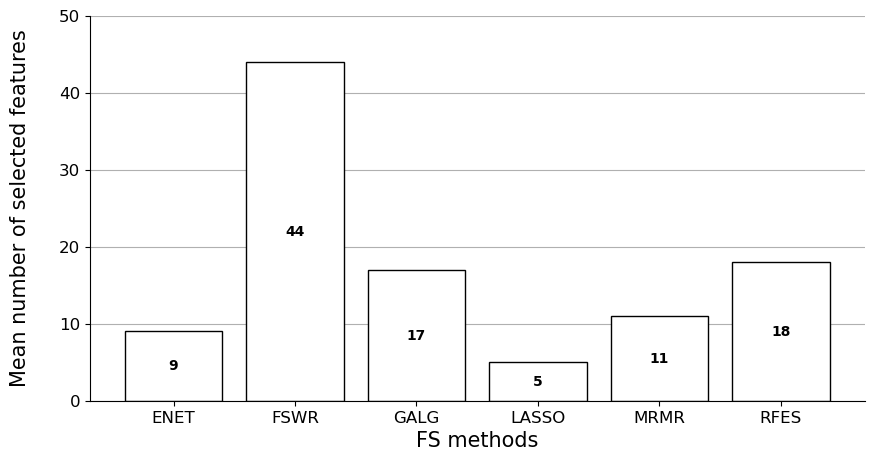

In [52]:
col_dict = {'LassoFeat':'LASSO', 'EnetFeat':'ENET', 'MRFeat':'MRMR', 'FFSFeat':'FSWR', 'GAFeat':'GALG', 'RFEFeat':'RFES'}

fig, ax = plt.subplots(figsize=(10, 5))
NumberOfFeat = NumberOfFeat.rename(col_dict).loc[['ENET', 'FSWR', 'GALG', 'LASSO', 'MRMR', 'RFES'], ]

temp = NumberOfFeat.T.mean().apply(np.ceil)
ax.bar(x=temp.index, height=temp, color='white', edgecolor='k', 
                                           
      )

for i in ax.containers:
    ax.bar_label(i, fmt = "%.0f", fontsize=10, fontweight='bold', zorder=6, label_type = 'center')
    
ax.set_xlabel('FS methods', fontsize=15)
ax.set_ylabel('Mean number of selected features\n', fontsize=15)

ax.set_xticks(ax.get_xticks(), temp.index,  fontsize=12)
ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int), fontsize=12)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_axisbelow(True)
ax.grid(axis='y', zorder=1)




Text(-6, 0.2, 'Mean Relative Root Mean Square Error')

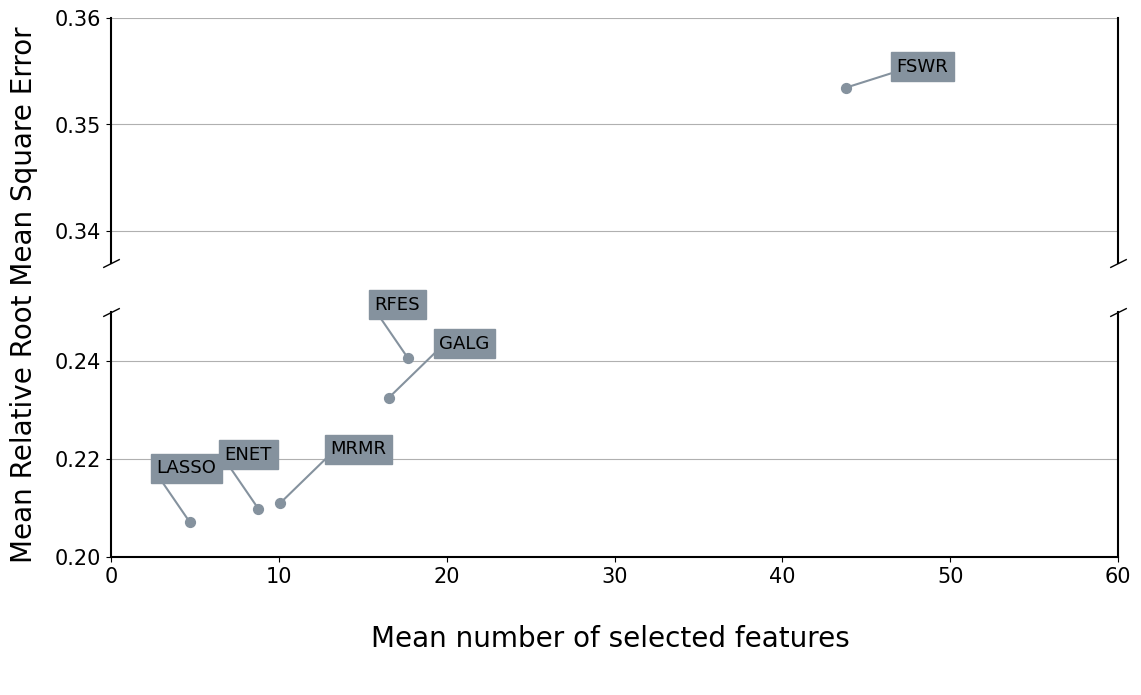

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)
Parsim = NumberOfFeat.T.mean().to_frame(name ='number_feat').assign(**Metric_res.query('OK_reg == "ROK"').select_dtypes('float').mean().rename(MetricName).to_frame())
lw = 1.5; ms = 50

ax1 = axes.flatten()[0]
ax1.scatter(data = Parsim, x='number_feat', y=MetricName,  s=ms, c='#85929E')
ax1.spines['right'].set_visible(True); 
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_linewidth(lw); ax1.spines['left'].set_linewidth(lw)

ax1.tick_params(axis='x',bottom=False, top=False,  labelbottom=False)
ax1.set_xlabel(None); ax1.set_ylabel(None)
ax1.set_ylim(0.337, 0.36)
ax1.set_yticks([0.34, 0.35, 0.36], [0.34, 0.35, 0.36], fontsize=15)

ax1.set_axisbelow(True)
ax1.grid(axis='y', zorder=1)
lcolor = '#85929E'
shifty = 0.0015
shiftx = 3
for i in range(Parsim.shape[0]):
    d = Parsim[['number_feat', MetricName]].iloc[i, :]
    if d.name != 'FSWR':
        continue
    ax1.text(d.values[0] + shiftx,d.values[1]+shifty , d.name, fontsize=13,  backgroundcolor='#85929E')
    ax1.plot([d.values[0], d.values[0]+shiftx], [d.values[1], d.values[1]+shifty], c=lcolor)

ax2 = axes.flatten()[1]
ax2.scatter(data = Parsim, x='number_feat', y=MetricName,  s=ms, c='#85929E')
ax2.spines['right'].set_visible(True); 
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_linewidth(lw); ax2.spines['right'].set_linewidth(lw)
ax2.spines['left'].set_linewidth(lw)
ax2.set_ylim(0.20, 0.25)
ax2.set_xlim(0, 51)
ax2.set_xlabel('\nMean number of selected features \n', fontsize=20)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticks().astype('int'),  fontsize=15)
ax2.set_yticks([0.2, 0.22, 0.24], ['0.20', '0.22', '0.24'], fontsize=15)




for i in range(Parsim.shape[0]):
    d = Parsim[['number_feat', MetricName]].iloc[i, :]
    if d.name == 'FSWR':
        continue
    if i % 2 != 0 or d.name == 'ENET' or d.name == 'LASSO':
        shifty = 0.01
        shiftx = -2
        
        ax2.text(d.values[0] + shiftx, d.values[1]+shifty , d.name, fontsize=13,  backgroundcolor='#85929E')
        plt.plot([d.values[0], d.values[0]+shiftx], [d.values[1], d.values[1]+shifty], c=lcolor)
    else:
        shifty = shifty 
        shiftx = -shiftx *1.5
        ax2.text(d.values[0] +  shiftx , d.values[1]+shifty , d.name, fontsize=13,  backgroundcolor='#85929E')
        ax2.plot([d.values[0] , d.values[0] + shiftx], [d.values[1], d.values[1]+shifty], c=lcolor)
    
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.set_axisbelow(True)
ax2.grid(axis='y', zorder=1)
#plt.text(-6, 0.234, f'Mean {MetricName}', fontsize=20, rotation=90)
plt.text(-6, 0.20, 'Mean Relative Root Mean Square Error', fontsize=20, rotation=90)


In [37]:
condition_index_values  = np.zeros((len(Quantiles), len(Methods)))

def condition_index(data):
    eigval = np.linalg.eigvals(data.corr())
    
    k = np.sqrt(eigval.max() / eigval.min())
    return k
    
for Q in range(len(Quantiles)):
    for VM in range(len(Methods)):
        varX = convertStrList(VarXSelected.loc[Methods[VM], Quantiles[Q]])
        condition_index_values[Q, VM] = condition_index(data[varX])

C:\Users\houndefr.EDUC\AppData\Local\Temp\5\ipykernel_11964\294102157.py:6: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(eigval.max() / eigval.min())
C:\Users\houndefr.EDUC\AppData\Local\Temp\5\ipykernel_11964\294102157.py:6: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(eigval.max() / eigval.min())
C:\Users\houndefr.EDUC\AppData\Local\Temp\5\ipykernel_11964\294102157.py:6: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(eigval.max() / eigval.min())


In [38]:
condition_index_values_df =  pd.DataFrame(condition_index_values.T , index=Methods, columns=Quantiles).rename(col_rename).round(2).fillna(200)

C:\Users\houndefr.EDUC\AppData\Local\Temp\5\ipykernel_11964\4291784139.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(0, 5000);


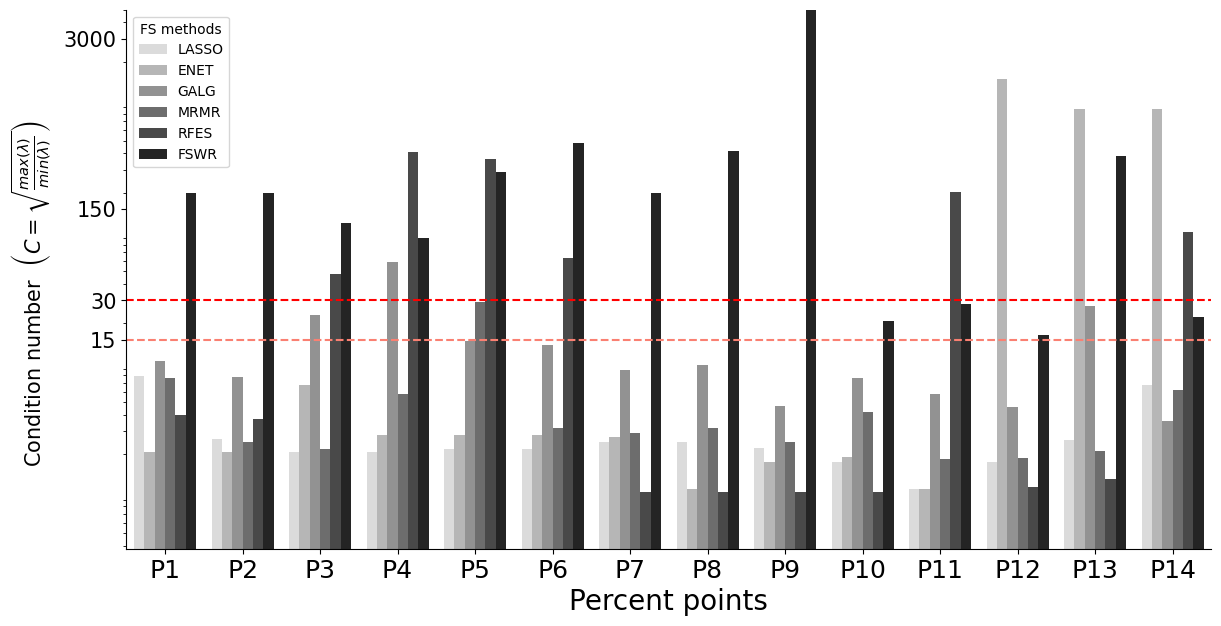

In [39]:
temp = condition_index_values_df.T.melt(ignore_index=False).reset_index().rename(columns={'index':'quantile', 'variable':'FS methods'})

fig, ax1 = plt.subplots( figsize=(14, 7))

sns.barplot(temp, x='quantile', y='value', hue='FS methods', palette='binary', ax=ax1)
ax1.set_xlabel('Percent points', fontsize=20)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_xticks(ax1.get_xticks(), labels= temp['quantile'].unique(), fontsize=18)
xlim = ax1.get_xlim()
ax1.hlines(15, *xlim, color='salmon', ls='--')
ax1.hlines(30, *xlim, color='r', ls='--')
ax1.set_xlim(*xlim)

#ax1.set_ylim(0, 40)
ax1.set_ylabel('')
ax1.text(-2, 2, 'Condition number  $\left(C = \sqrt{\\frac{max(\lambda)}{min(\lambda)}}\\right)$ ', fontsize=15, rotation=90)

ax1.set_yscale('log')
ax1.set_yticks([ 15, 30, 150, 3000 ],[  15, 30, 150, 3000], fontsize=15);
ax1.set_ylim(0, 5000);


In [40]:
condition_index_values_df.lt(15).sum(1)

LASSO    14
ENET     11
GALG     11
MRMR     13
RFES      8
FSWR      0
dtype: int64

In [41]:
all_var = pd.DataFrame()
#var = defaultdict(list)

p = VarXSelected.columns[0]
VarXSelected_list = [*VarXSelected.loc[:, p].str.strip('[]').astype('str').str.split('\s')]
VarXSelected_list = [v.strip("/'/'") for var in VarXSelected_list for v in var if len(v) > 0]
count_var = Counter(VarXSelected_list).most_common(10)
all_var = pd.Series(dict(count_var), name = p).to_frame()

for p in VarXSelected.columns[1:]:
    

    VarXSelected_list = [*VarXSelected.loc[:, p].str.strip('[]').astype('str').str.split('\s')]
    VarXSelected_list = [v.strip("/'/'") for var in VarXSelected_list for v in var if len(v) > 0]
    
    count_var = pd.Series(dict(Counter(VarXSelected_list).most_common(10)), name=p).to_frame()
    
    all_var = all_var.merge(count_var, left_index=True, right_index=True, how='outer')

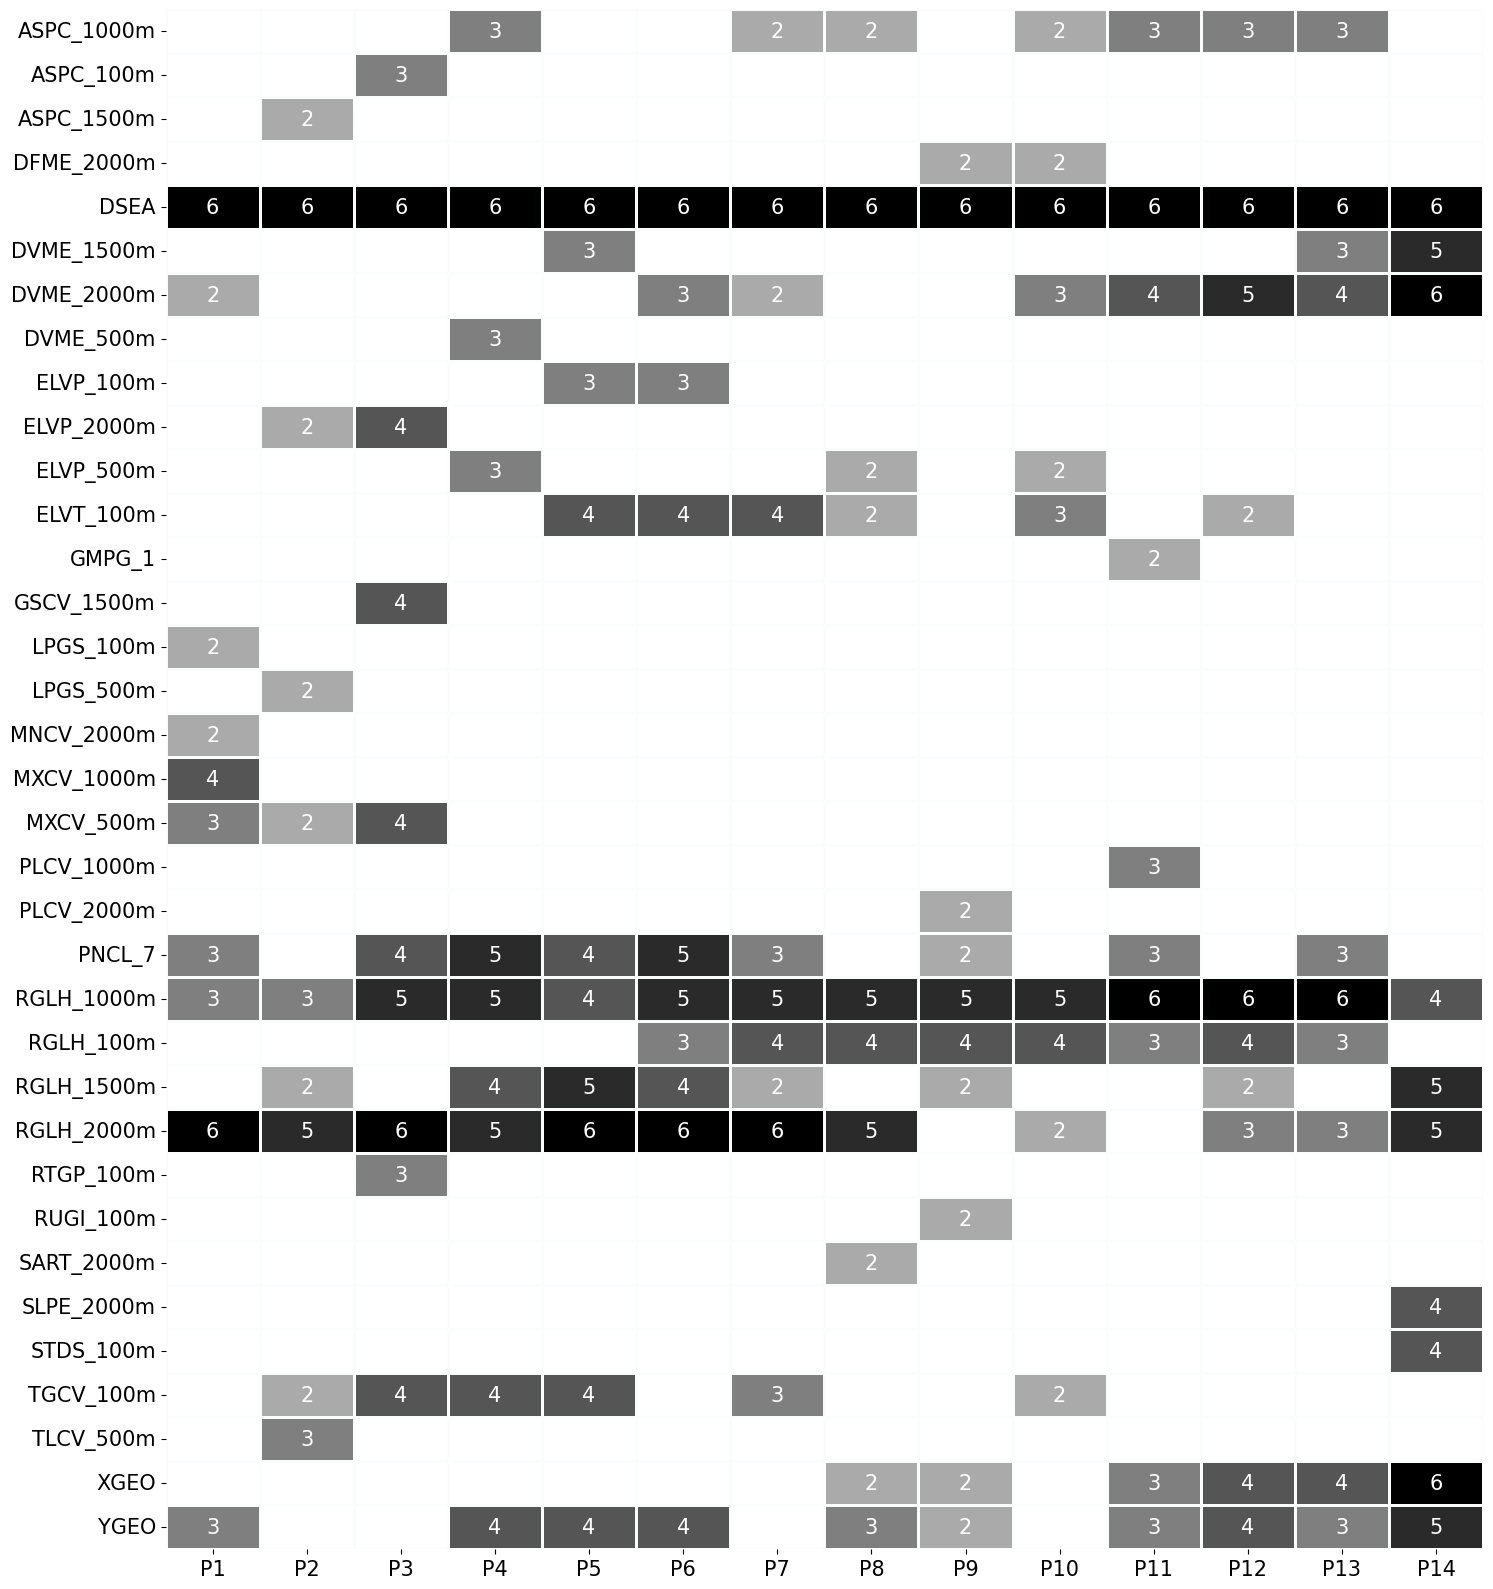

In [42]:
fig, ax = plt.subplots(figsize=(17, 20))
sns.heatmap(all_var.rename(index = Explanatory_dict).sort_index(),
            cmap=plt.cm.binary, annot=True, vmin=0, vmax=6, cbar=False, ax=ax, 
            linewidths=0.8, linecolor='#FBFCFC', fmt='g', annot_kws={"fontsize":15})
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize=15);
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=15);

In [43]:
Lasso_all_Features = [convertStrList(VarXSelected.loc['LassoFeat', p]) for p in VarXSelected.columns]
Lasso_all_Features = [Explanatory_dict.get(var) for variables in Lasso_all_Features for var in variables]
Lasso_all_Features = np.unique(Lasso_all_Features)

coeff_all = pd.DataFrame( index = Lasso_all_Features)
test_prediction = {}
for p in VarXSelected.columns:

    X_scaler = StandardScaler()
    Y_scaler = StandardScaler()

    varX = convertStrList(VarXSelected.loc['MRFeat', p])
    X_train = pd.DataFrame(X_scaler.fit_transform(data[varX]), columns=varX)
    X_test = pd.DataFrame(X_scaler.transform(data_val[varX]), columns=varX)
    Y_train = Y_scaler.fit_transform(data[[p[1:]]])

    model = sm.OLS(Y_train, X_train)

    res = model.fit()
    test_prediction[p] = Y_scaler.inverse_transform(res.predict(X_test).values.reshape(-1, 1))
    coef = (res.params.to_frame().rename(columns={ 0:f'{p}'})
            .reset_index().replace(Explanatory_dict)
            .set_index('index')
            #.sort_values(, key=np.abs, ascending=False)
           )
    coeff_all = coeff_all.merge(coef, how = 'left', left_index=True, right_index=True)


In [44]:
# fig, axes = plt.subplots(7, 2, figsize=(10, 30))
# for i, p in enumerate(VarXSelected.columns):
#     ax = axes.flatten()[i]
#     ax.plot(data_val[p[1:]], test_prediction[p], 'o', alpha=0.5)
#     print(r2_score(data_val[p[1:]], test_prediction[p]))
#     ax.scatter(data_val[p[1:]], data_val[p[1:]] - test_prediction[p].flatten(), c='k', alpha=0.5)
#     minx = data_val[p[1:]].min()
#     maxx = data_val[p[1:]].max()
#     ax.plot([minx, maxx], [minx, maxx], 'k--')
#     ax.axhline(0, c='k', alpha=0.5)
    

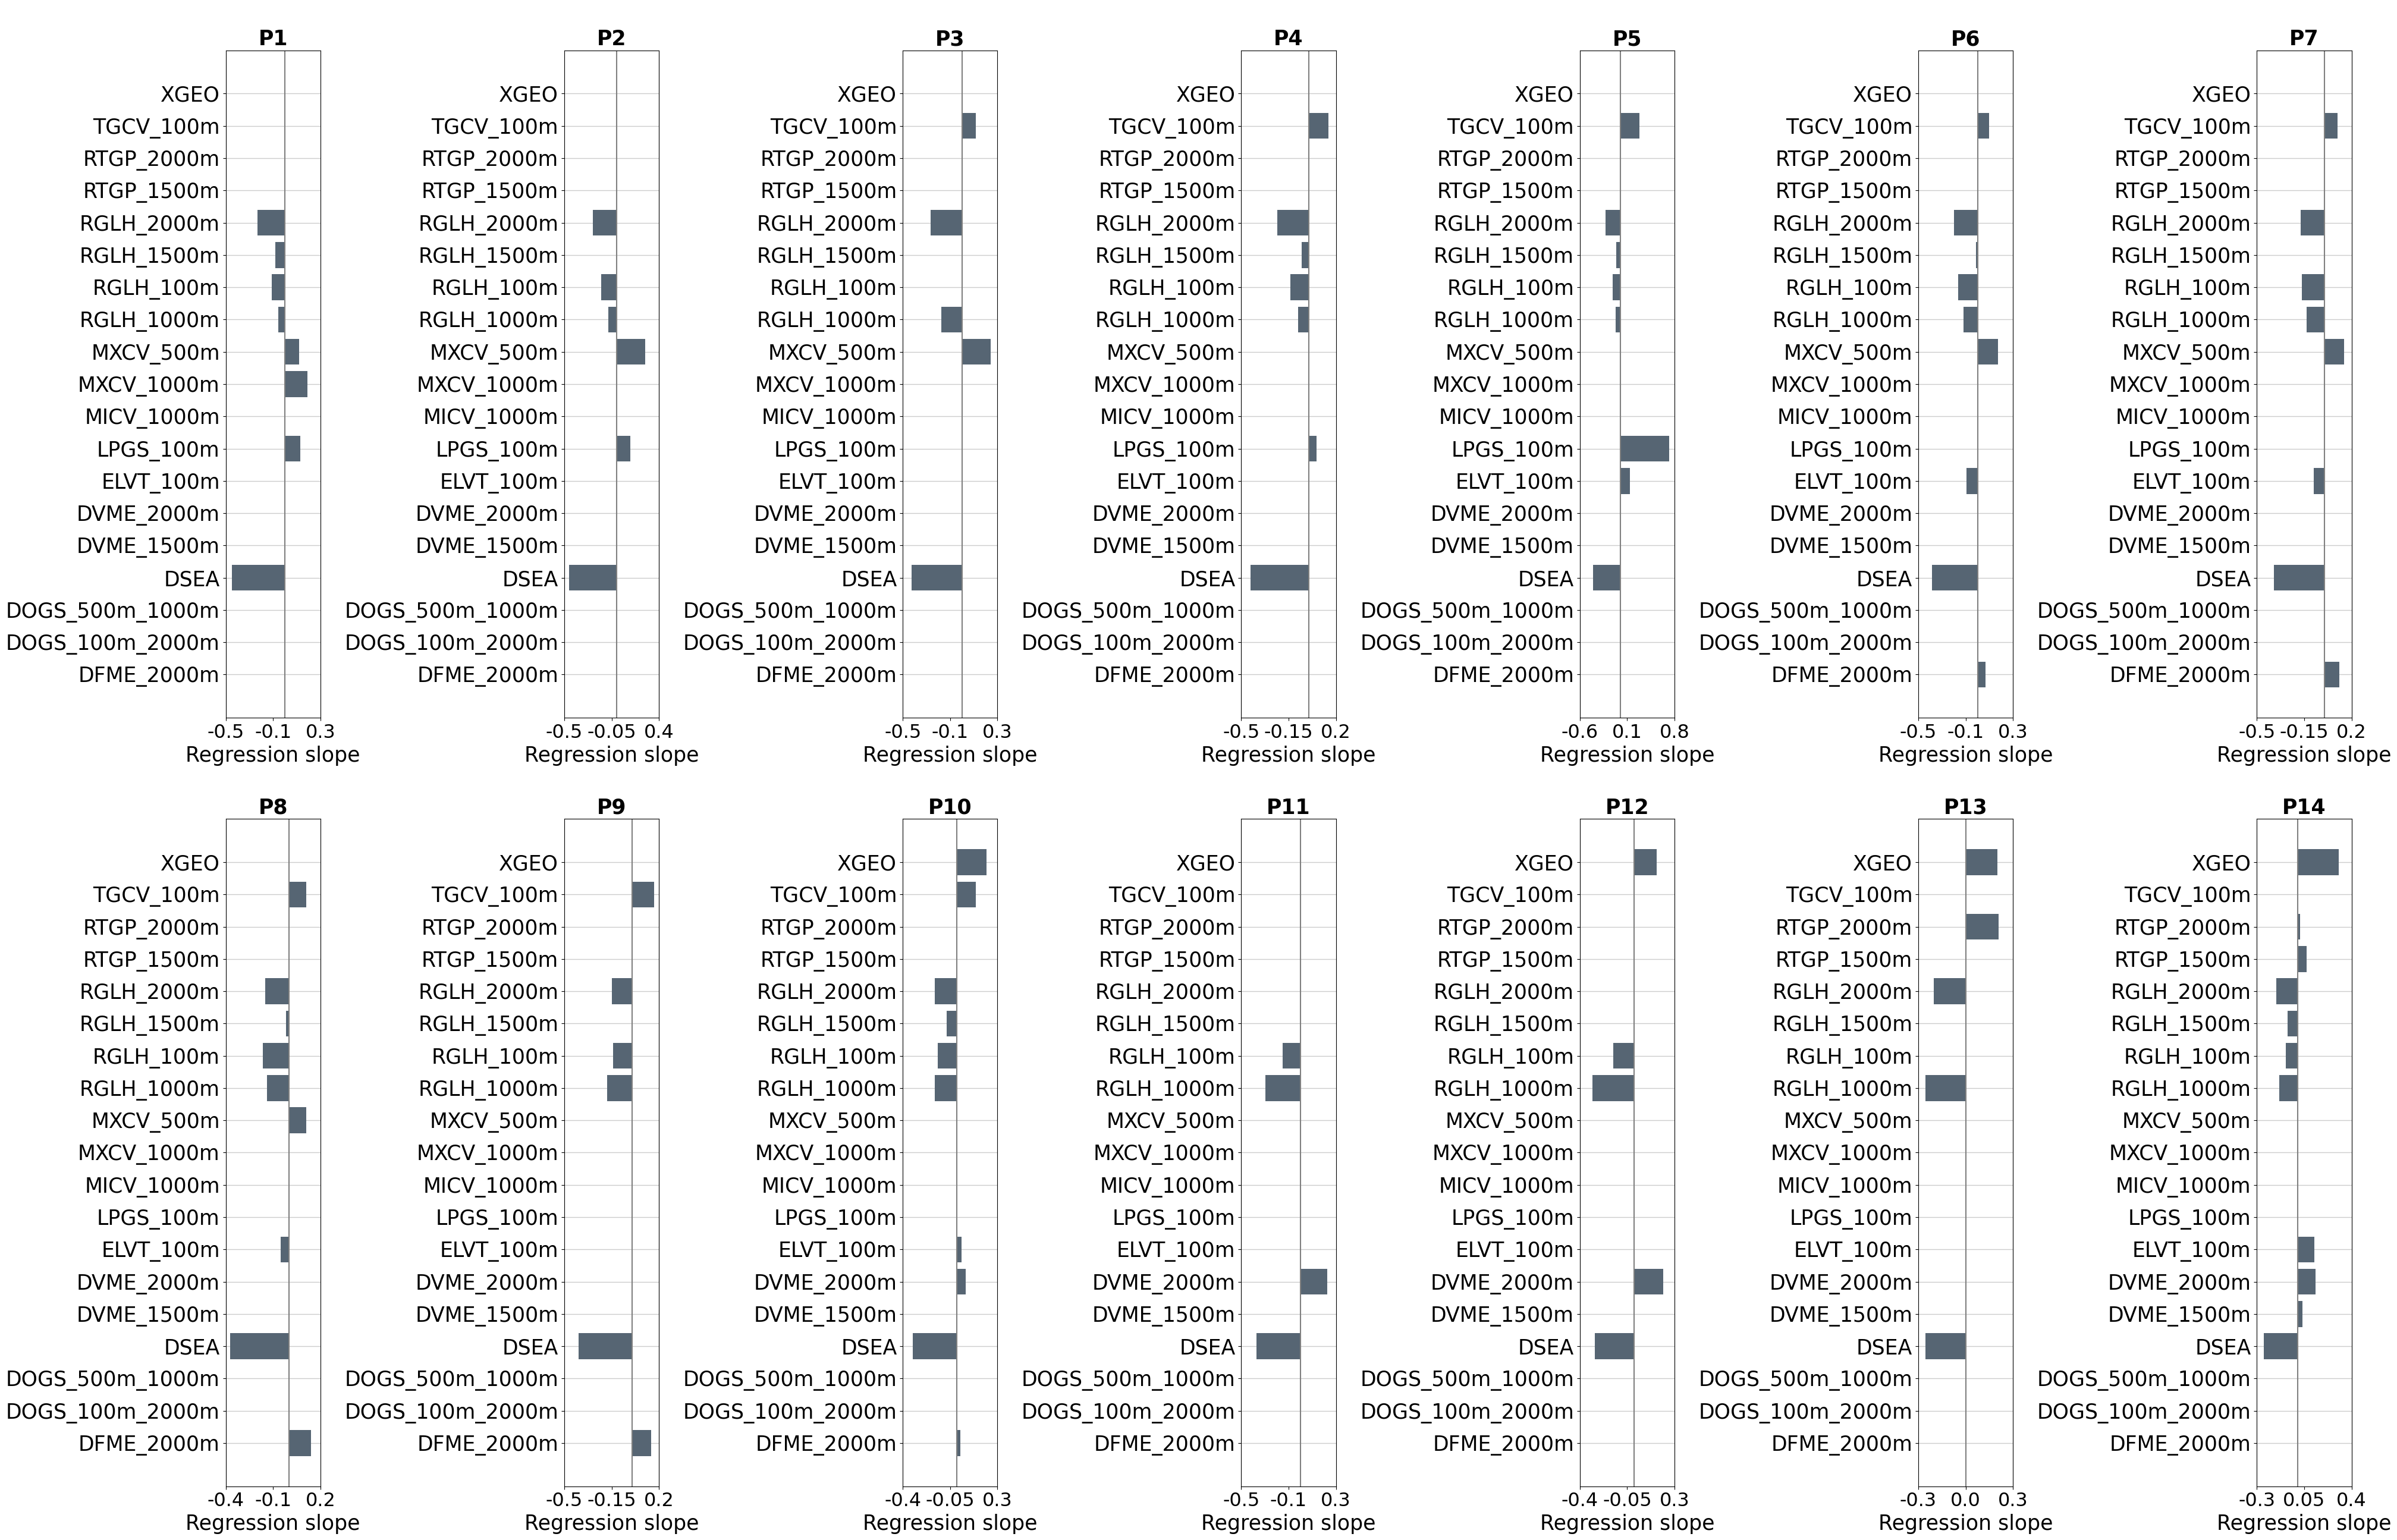

In [45]:
fig, axess = plt.subplots(2, 7, figsize=(40, 26))

coeff_all = coeff_all.sort_index().fillna(0) #sort the index of the dataframe 
for i, p in enumerate(coeff_all.columns):
    ax = axess.flatten()[i]
    
    ax.barh(width= coeff_all[p], y=coeff_all.index,  color='#566573', zorder=2)
    ax.axvline(x=0, color=".5")
    ax.set_title(f'\n{p}', fontsize=25, fontweight='bold')
    ax.set_xlabel('Regression slope', fontsize=25)
    ax.set_yticks(ax.get_yticks(), labels=coeff_all.index, fontsize=25)
    xticks = ax.get_xticks().round(2)
    xticks = [xticks.min(), xticks.mean(), xticks.max()]
    ax.set_xticks(xticks, np.round(xticks, 2), fontsize=23)
    ax.grid(axis='y', color='k', linestyle='-', linewidth=1, alpha=0.2, zorder=1)

plt.tight_layout()   


In [46]:
def predict(varY, train, test, varSelectMethod='MRFeat', Xscaler=StandardScaler(), Yscaler=StandardScaler()):
    varX = convertStrList(VarXSelected.loc[varSelectMethod, varY])
    X_train = pd.DataFrame(Xscaler.fit_transform(train[varX]), columns=varX)
    X_test = pd.DataFrame(Xscaler.transform(test[varX]), columns=varX)
    Y_train = Yscaler.fit_transform(train[[varY[1:]]])
    Model = LinearRegression()
    Model.fit(X_train, Y_train)
    return Yscaler.inverse_transform(Model.predict(X_test)).flatten()

In [47]:
MRMR_pred = {}
LASSO_pred = {}

for p in VarXSelected.columns:

    
    MRMR_pred[p] = predict(p, data, data_val, varSelectMethod='MRFeat')
    LASSO_pred[p] = predict(p, data, data_val, varSelectMethod='LassoFeat')

In [48]:
true_df = data_val.set_index('site').loc[:, '1':'14'].rename(columns=lambda x: "P"+x ) * kms_to_ms
MRMR_pred_df = pd.DataFrame(MRMR_pred, index = data_val.site) * kms_to_ms
LASSO_pred_df = pd.DataFrame(LASSO_pred, index = data_val.site) * kms_to_ms

In [49]:
greys_color = sns.color_palette(["#080808", "#1F2020", "#2A2B2C", "#363738",
                    "#414244", "#4C4D4F", "#57595B", "#626466",
                      "#6D7072", "#787C78", "#838885", "#8E9492", 
                      "#999D9F", "#A4A8AB", 
                   ])

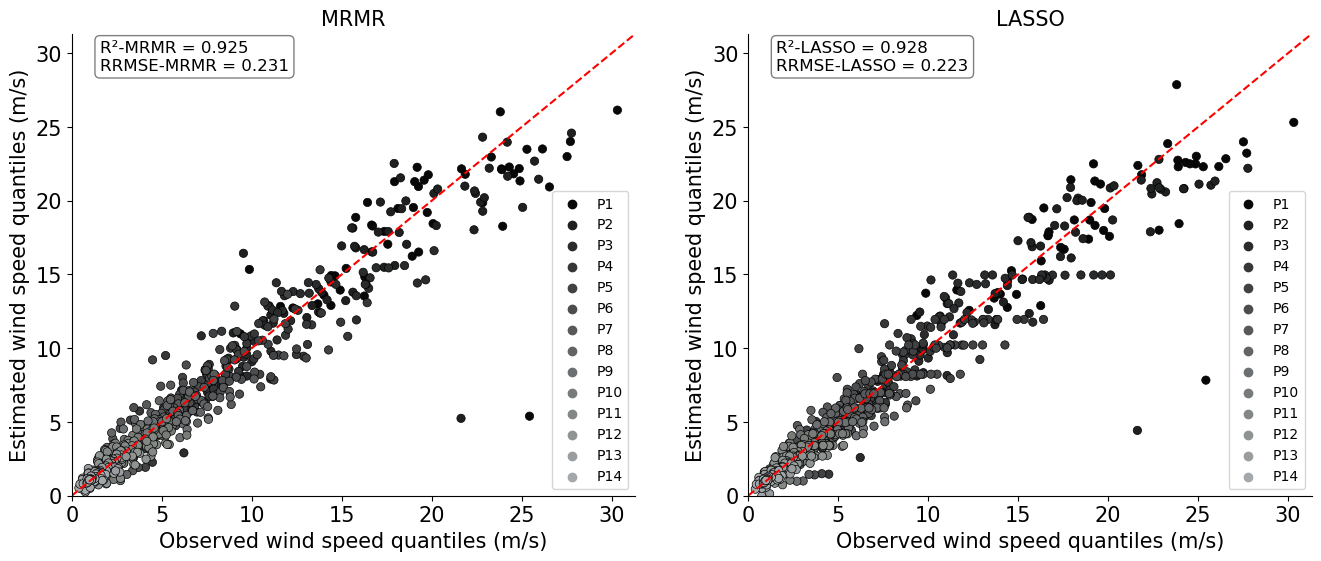

In [50]:
temp = (true_df.unstack().reset_index().rename(columns={0:'Q_true', 'level_0':'Percentile'})
 
 .merge(MRMR_pred_df.unstack().reset_index().rename(columns={0:'Q_MRMR', 'level_0':'Percentile'}), on=['site', 'Percentile'])
 .merge(LASSO_pred_df.unstack().reset_index().rename(columns={0:'Q_LASSO', 'level_0':'Percentile'}), on=['site', 'Percentile'])
 
 )



fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax0, ax1 = axes.flatten()

sns.scatterplot(data=temp, x='Q_true', y='Q_MRMR', hue='Percentile', palette=greys_color, ax=ax0, edgecolor="k")
r2MRMR = np.round(r2_score(temp.Q_true, temp.Q_MRMR), 3)
rrmseMRMR = np.round(rrmse(temp.Q_true, temp.Q_MRMR), 3) 
text  = f"R²-MRMR = {r2MRMR}\nRRMSE-MRMR = {rrmseMRMR}"

props = dict(boxstyle='round', facecolor='w', alpha=0.5)
ax0.text(0.05, 0.95, text, 
         horizontalalignment='left', 
         verticalalignment='center', transform=ax0.transAxes, 
         fontsize=12, bbox=props)
maxv = temp.Q_true.max() + 1
ax0.plot([0, maxv], [0, maxv], ls="--", c="r")
ax0.set_xticks(ax0.get_xticks(), ax0.get_xticks().astype(int), fontsize=15)
ax0.set_yticks(ax0.get_yticks(), ax0.get_yticks().astype(int), fontsize=15);
ax0.set_ylabel('Estimated wind speed quantiles (m/s)', fontsize=15)
ax0.set_xlabel('Observed wind speed quantiles (m/s)', fontsize=15)
ax0.set_title('MRMR', fontsize=15)
ax0.set_xlim(0, maxv)
ax0.set_ylim(0, maxv)
ax0.legend(loc='lower right', fontsize=10)
#######################################################



sns.scatterplot(data=temp, x='Q_true', y='Q_LASSO', hue='Percentile', palette=greys_color, ax=ax1, edgecolor="k")
r2LASSO = np.round(r2_score(temp.Q_true, temp.Q_LASSO), 3)
rrmseLASSO = np.round(rrmse(temp.Q_true, temp.Q_LASSO), 3)
text  = f"R²-LASSO = {r2LASSO}\nRRMSE-LASSO = {rrmseLASSO}"

props = dict(boxstyle='round', facecolor='w', alpha=0.5)
ax1.text(0.05, 0.95, text, 
         horizontalalignment='left', 
         verticalalignment='center', transform=ax1.transAxes, 
         fontsize=12, bbox=props)
maxv = temp.Q_true.max() + 1
ax1.plot([0, maxv], [0, maxv], ls="--", c="r")
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticks().astype(int), fontsize=15)
ax1.set_yticks(ax1.get_yticks(), ax1.get_yticks().astype(int), fontsize=15);
ax1.set_ylabel('Estimated wind speed quantiles (m/s)', fontsize=15)
ax1.set_xlabel('Observed wind speed quantiles (m/s)', fontsize=15)
ax1.set_xlim(0, maxv)
ax1.set_ylim(0, maxv)
ax1.set_title('LASSO', fontsize=15)
ax1.legend(loc='lower right', fontsize=10)
sns.despine()


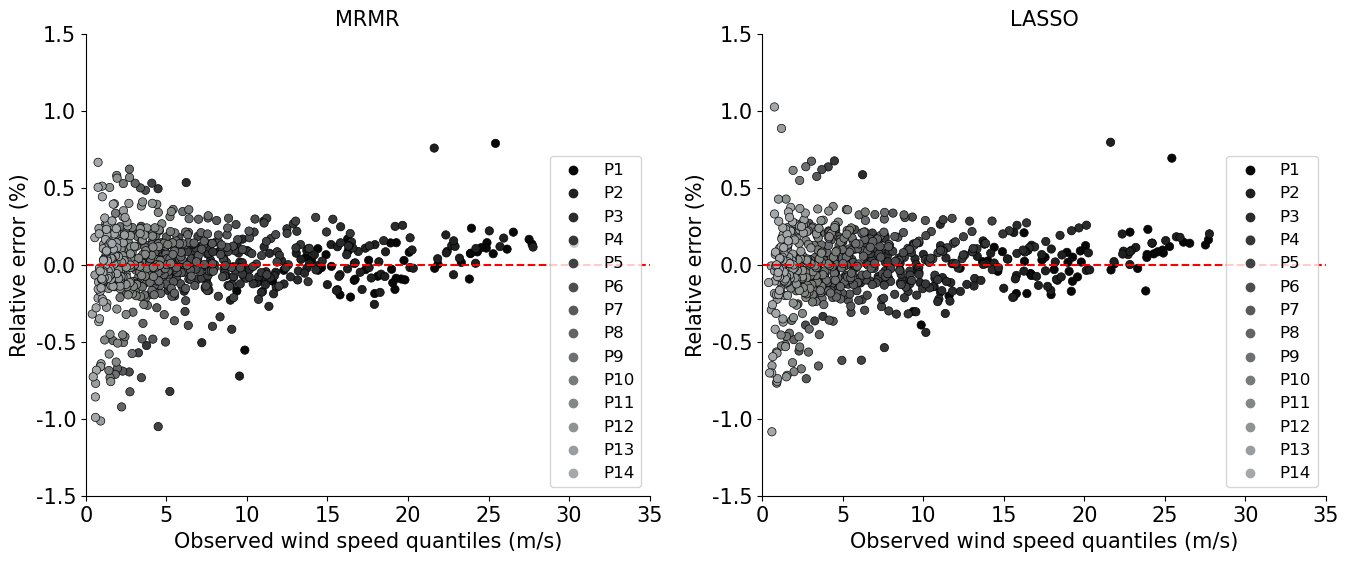

In [51]:
temp = (true_df.unstack()
 .reset_index()
 .rename(columns={0:'true', "level_0":"Percentiles"})
 .merge((((true_df - MRMR_pred_df).unstack())/true_df.unstack())
        .reset_index()
        .rename(columns={0:'error_MRMR', "level_0":"Percentiles"}))
    .merge((((true_df - LASSO_pred_df).unstack())/true_df.unstack())
           .reset_index()
              .rename(columns={0:'error_LASSO', "level_0":"Percentiles"}))
           
           ) 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax0, ax1 = axes.flatten()
sns.scatterplot(data=temp, x='true', y='error_MRMR', hue='Percentiles', palette=greys_color, ax=ax0, edgecolor="k")
ax0.axhline(0, color='r', linestyle='--')
ax0.set_ylim(-1.5, 1.5)
ax0.set_xlim(0, 35)
ax0.set_xticks(ax0.get_xticks(), ax0.get_xticks().astype('int'), fontsize=15)
ax0.set_yticks(ax0.get_yticks(), ax0.get_yticks(), fontsize=15)
ax0.set_title('MRMR', fontsize=15)
ax0.set_ylabel('Relative error (%)', fontsize=15)
ax0.set_xlabel('Observed wind speed quantiles (m/s)', fontsize=15);
ax0.legend(loc='lower right', fontsize=12);
##########################################################
sns.scatterplot(data=temp, x='true', y='error_LASSO', hue='Percentiles', palette=greys_color, ax=ax1, edgecolor="k")
sns.despine()
ax1.axhline(0, color='r', linestyle='--')
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlim(0, 35)
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticks().astype('int'), fontsize=15);
ax1.set_yticks(ax1.get_yticks(), ax1.get_yticks(), fontsize=15);
ax1.set_ylabel('Relative error (%)', fontsize=15);
ax1.set_title('LASSO', fontsize=15)
ax1.set_xlabel('Observed wind speed quantiles (m/s)', fontsize=15);
ax1.legend(loc='lower right', fontsize=12);

